# **Demo notebook in Uplift Modeling**

- Dataset
  - Adding monetary information to our datset
- Exploratory Data Analysis (EDA)
- Estimating the Conditional Treatment Effect
  - Feature Selection
  - Modeling the Incrementality in Conversion
    - Evaluating the CATE conversion model
  - Modeling the Incrementality in Benefit
    - Evaluating the Incrementality in Benefit

In [28]:
# ! pip install causalml==0.14.1
# ! conda install -c conda-forge causalml

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from causalml.metrics import *
from causalml.dataset import make_uplift_classification
from xgboost import XGBRegressor, XGBClassifier

import warnings
warnings.filterwarnings('ignore')

/Users/oleksandrhonchar/opt/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


# **Dataset**

The first step is to create a simulated dataset, representative of data collected from a Randomized Control Trial (RCT) where 200.000 customers were equally split between 4 different variants:
- Control (no discount)
- 5% discount
- 10% discount
- 15% discount

The probability of a user to make a purchase (convert) in the control group is a function of a number of simulated features called **informative features**. In the discounted variants, other features also influence the conversion probability by adding uplift as a result of the discount, called **uplift features**. We also have features with no effect at all, called **irrelevant features**.

**The dataset contains:**
- Which variant the customer was assigned to.
- The discount percentage of the variant.
- The features (informative, irrelevant, uplift, etc).
- The binary conversion label.

To create the simulated dataset we use the CausalML open source package, which gives us enough flexibility regarding features and interactions.

In [3]:
# define parameters for simulation
n = 50000
y_name = 'conversion'
treatment_group_keys = ['control', 'discount_05', 'discount_10', 'discount_15']
n_classification_features = 15
n_classification_informative = 7
n_classification_repeated = 0
n_uplift_increase_dict = {'discount_05': 4, 'discount_10': 3, 'discount_15': 3}
n_uplift_decrease_dict = {'discount_05': 0, 'discount_10': 0, 'discount_15': 0}
delta_uplift_increase_dict = {'discount_05': 0.0020, 'discount_10': 0.0045, 'discount_15': 0.008}
delta_uplift_decrease_dict = {'discount_05': 0, 'discount_10': 0, 'discount_15': 0}
n_uplift_increase_mix_informative_dict = {'discount_05': 3, 'discount_10': 2, 'discount_15': 3}
n_uplift_decrease_mix_informative_dict = {'discount_05': 0, 'discount_10': 0, 'discount_15': 0}
positive_class_proportion = 0.05
random_seed = 8097

# simulate dataset
df, X_names = make_uplift_classification(
    treatment_name=treatment_group_keys,
    y_name=y_name,
    n_samples=n,
    n_classification_features=n_classification_features,
    n_classification_informative=n_classification_informative,
    n_classification_repeated=n_classification_repeated,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict = delta_uplift_increase_dict,
    delta_uplift_decrease_dict = delta_uplift_decrease_dict,
    n_uplift_increase_mix_informative_dict = n_uplift_increase_mix_informative_dict,
    n_uplift_decrease_mix_informative_dict = n_uplift_decrease_mix_informative_dict,
    positive_class_proportion = positive_class_proportion,
    random_seed=random_seed,
)

discounts_dict = {'control': 0, 'discount_05':0.05, 'discount_10':0.10, 'discount_15':0.15}
df['discount'] = df['treatment_group_key']
df = df.replace({"discount": discounts_dict})
df.drop(columns=['treatment_effect'], inplace=True)

In [4]:
df.head()

treatment_group_key  x1_informative  x2_informative  x3_informative  \
0         discount_05       -0.042262       -0.227152       -4.008524   
1         discount_15       -0.661554       -0.753436        0.810210   
2         discount_15        0.709849       -0.411880       -2.189072   
3             control       -0.123754        0.553320        0.411789   
4         discount_15        1.169897       -0.093619       -0.592952   

   x4_informative  x5_informative  x6_informative  x7_informative  \
0       -3.677508       -1.041108       -0.458535       -0.738112   
1       -1.777876       -1.815303        0.010383        1.086347   
2       -0.459654       -1.341218        1.091933        1.725541   
3       -0.973973        0.798154       -0.129048       -0.900563   
4        1.796628       -1.135799       -0.070309       -1.971987   

   x8_irrelevant  x9_irrelevant  ...  x26_increase_mix  x27_increase_mix  \
0      -1.454540       0.324614  ...          2.818832          0.605656   
1       0.663161      -1.106134  ...         -0.485384         -1.030500   
2       0.587434      -0.214160  ...          0.262162         -1.072919   
3       0.174573       1.199244  ...         -0.825072         -0.748441   
4       0.548906      -0.409969  ...         -0.774489          0.657385   

   x28_uplift_increase  x29_uplift_increase  x30_uplift_increase  \
0             1.113880             1.416118            -0.881965   
1            -0.527096             1.424322            -1.022723   
2             1.906866            -0.568036            -1.013307   
3             1.830809             1.032815             0.599434   
4             1.511193             1.849122            -0.894096   

   x31_increase_mix  x32_increase_mix  x33_increase_mix  conversion  discount  
0          4.401370         -0.324652         -0.830702           0      0.05  
1         -1.190952          1.186895          0.232637           0      0.15  
2          3.699528          1.698517         -2.072810           0      0.15  
3          1.489121         -0.908026         -1.433424           0      0.00  
4          1.994741         -1.314116         -0.915712           0      0.15  

[5 rows x 36 columns]

### **Adding monetary information to our dataset**

So far the label of our dataset is the binary conversion column indicating if the customer made a purchase or not. Now we want to add information about the size of the purchase (amount paid) and the platform's revenue.

We will make a distinction between 2 types of prices:
- **Base Price**: total price of the purchase before applying the discount.
- **Discounted Price**: total price of the purchase after applying the
relevant discount. This is the price the customer actually pays.

For simplicity we will assume that the Base Price of a purchase is NOT affected by a discount offering. This means that we do allow a discount to have an effect on the customer probability of purchase completion, but we assume customers don't change the products they planned on purchasing because of a discount (like buying more expensive products because of a discount for example).

To materialize the above, we will simulate the Base Price in our dataset as a function of the Informative features only.

The Discounted Price on the other hand is of course affected by the discount, but as a close expression of the Base Price:

**Discounted Price = Base Price * (1 - Discount%)**

We can also add information about the benfit (profit) that the ecommerce platform takes from the purchase, which is one of the things we might want to optimize for. We will assume the margin of the platform is 20% of the Base Price. When giving a discount we are in fact giving away part of this margin.

**Benefit = 20% * Base Price - (Base Price - Discounted Price)**

**Benefit = Discounted Price - 80% * Base Price**

In [5]:
from random import randint

def base_price(df, informative_features):

  if df.conversion == 0:
    base_price = 0
  else:
    base_price = randint(1, 100)
  return base_price

informative_features = [k for k in X_names if 'informative' in k]
df['base_price'] = df.apply(lambda x: base_price(x, informative_features), axis=1)
df['discounted_price'] = df['base_price']*(1-df['discount'])
df['benefit'] = df['discounted_price']-0.8*df['base_price']

# **Exploratory Data Analysis**

We can begin by computing the total sum of conversions, sales (discounted price) and platform benefit. We can see that the total conversions and the total sales grows as the discount value is bigger. However the platform benefit decreases.

In [6]:
df_pivot = df.pivot_table(values=['conversion','discounted_price','benefit'],
               index='treatment_group_key',
               aggfunc=[np.sum],
               margins=False)
df_pivot

sum                            
                      benefit conversion discounted_price
treatment_group_key                                      
control              27973.00       2739        139865.00
discount_05          22743.00       3002        144039.00
discount_10          15970.40       3147        143733.60
discount_15           8447.25       3352        143603.25

We can repeat the analysis but using the mean instead of the sum. This will give us the mean conversion rate, the mean sales per user and the mean platform benefit per user.

In [7]:
df_pivot = df.pivot_table(values=['conversion','discounted_price','benefit'],
               index='treatment_group_key',
               aggfunc=[np.mean],
               margins=False)
df_pivot

mean                            
                      benefit conversion discounted_price
treatment_group_key                                      
control              0.559460    0.05478         2.797300
discount_05          0.454860    0.06004         2.880780
discount_10          0.319408    0.06294         2.874672
discount_15          0.168945    0.06704         2.872065

To illustrate the tradeoff between conversions and platform benefit we can plot the mean benefit per user in the y-axis and the mean conversion rate in the x-axis, per treatment group.

<AxesSubplot: xlabel='conversion', ylabel='benefit'>

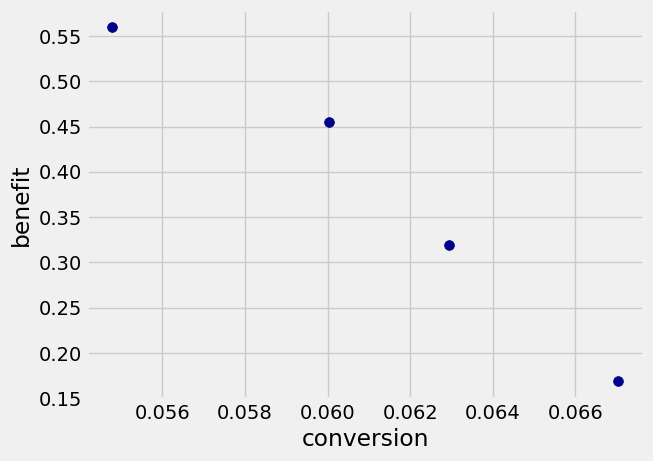

In [8]:
import matplotlib.pyplot as plt

df_pivot_mean = df_pivot[['mean']]
df_pivot_mean.columns = df_pivot_mean.columns.droplevel()
df_pivot_mean.plot.scatter(x='conversion',
                      y='benefit',
                      c='DarkBlue',
                      s=50,
                      )

We can also compute the Average Treatment Effect (ATE) for both the mean conversion rate and the mean benefit per user:
- Conversion ATE = Mean Converstion rate in discounted group minus Mean Conversion rate in control group
- Benefit ATE = Mean Benefit per user in discounted group minus Mean Benefit per user in control group

We can see in the plot below that the bigger the discount value the stronger the Conversion ATE (x-axis), but at the same time the more negative the Benefit ATE (y-axis).

<AxesSubplot: xlabel='conversion_ate', ylabel='benefit_ate'>

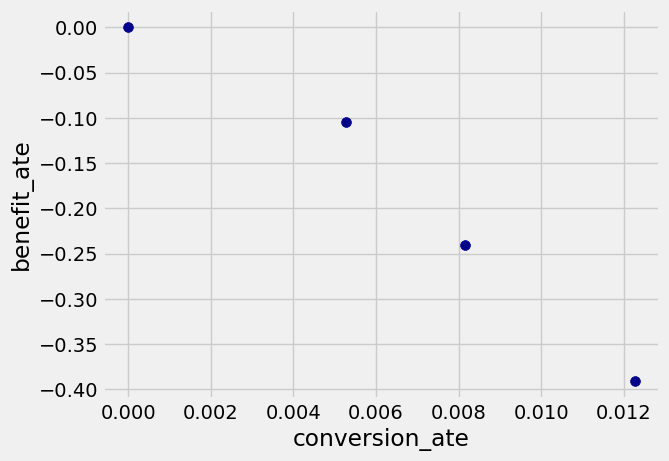

In [9]:
df_pivot_mean_ate = df_pivot_mean - df_pivot_mean.loc['control'].values.squeeze()
df_pivot_mean_ate.columns = ['benefit_ate', 'conversion_ate', 'discounted_price_ate']
df_pivot_mean_ate.plot.scatter(x='conversion_ate',
                      y='benefit_ate',
                      c='DarkBlue',
                      s=50,
                      )

# **Estimating the Conditional Treatment Effect**

So far we analyzed the average performance of the 5%, 10% and 15% discounts. Now we want to see if we can model the impact each discount has at the user level, by using the available features.



# **Feature Selection**

When working with a high number of available features, we can consider using Feature Selection techniques to identify the most informative features in regards to modeling the causal effect of the treatment.

The CausalML package offers a collection of approaches for Feature Selection, more information [here](https://causalml.readthedocs.io/en/latest/examples/feature_selection.html) and [here](https://causalml.readthedocs.io/en/latest/_modules/causalml/feature_selection/filters.html).

Feature selection can be treatment dependent, here we show an example when analyzing the 15% discount treatment group.


In [10]:
from causalml.feature_selection.filters import FilterSelect

In [11]:
filter_method = FilterSelect()

method = 'KL'
kl_imp = filter_method.get_importance(df, X_names, y_name, method,
                      treatment_group = 'discount_15',
                      n_bins=20)
kl_imp.head(100)

method              feature  rank     score p_value                misc
0  KL filter       x4_informative   1.0  0.005331    None  number_of_bins: 20
0  KL filter     x26_increase_mix   2.0  0.004927    None  number_of_bins: 20
0  KL filter     x33_increase_mix   3.0  0.004518    None  number_of_bins: 20
0  KL filter       x3_informative   4.0  0.004102    None  number_of_bins: 20
0  KL filter  x29_uplift_increase   5.0  0.004047    None  number_of_bins: 20
0  KL filter  x28_uplift_increase   6.0  0.003885    None  number_of_bins: 20
0  KL filter  x30_uplift_increase   7.0  0.003559    None  number_of_bins: 20
0  KL filter     x22_increase_mix   8.0  0.003275    None  number_of_bins: 20
0  KL filter     x31_increase_mix   9.0  0.002813    None  number_of_bins: 20
0  KL filter     x21_increase_mix  10.0  0.002684    None  number_of_bins: 20
0  KL filter  x23_uplift_increase  11.0  0.001997    None  number_of_bins: 20
0  KL filter  x25_uplift_increase  12.0  0.001855    None  number_of_bins: 20
0  KL filter       x10_irrelevant  13.0  0.001810    None  number_of_bins: 20
0  KL filter  x24_uplift_increase  14.0  0.001718    None  number_of_bins: 20
0  KL filter       x6_informative  15.0  0.001614    None  number_of_bins: 20
0  KL filter     x27_increase_mix  16.0  0.001560    None  number_of_bins: 20
0  KL filter       x1_informative  17.0  0.001507    None  number_of_bins: 20
0  KL filter       x11_irrelevant  18.0  0.001403    None  number_of_bins: 20
0  KL filter        x8_irrelevant  19.0  0.001340    None  number_of_bins: 20
0  KL filter  x16_uplift_increase  20.0  0.001275    None  number_of_bins: 20
0  KL filter       x14_irrelevant  21.0  0.001246    None  number_of_bins: 20
0  KL filter     x20_increase_mix  22.0  0.001242    None  number_of_bins: 20
0  KL filter       x15_irrelevant  23.0  0.001233    None  number_of_bins: 20
0  KL filter  x17_uplift_increase  24.0  0.001177    None  number_of_bins: 20
0  KL filter       x12_irrelevant  25.0  0.001143    None  number_of_bins: 20
0  KL filter       x13_irrelevant  26.0  0.001022    None  number_of_bins: 20
0  KL filter     x32_increase_mix  27.0  0.001010    None  number_of_bins: 20
0  KL filter       x7_informative  28.0  0.000977    None  number_of_bins: 20
0  KL filter       x5_informative  29.0  0.000951    None  number_of_bins: 20
0  KL filter  x18_uplift_increase  30.0  0.000920    None  number_of_bins: 20
0  KL filter  x19_uplift_increase  31.0  0.000901    None  number_of_bins: 20
0  KL filter       x2_informative  32.0  0.000855    None  number_of_bins: 20
0  KL filter        x9_irrelevant  33.0  0.000832    None  number_of_bins: 20

As we can see, most of the Informative and the Increase features are ranked at the top of the Features Rank, while most of the Irrelevant features are ranked at the bottom.

From here we could continue to the modeling section with a, for example, top10 selection of features based on our Feature Selection ranking. But for the purposes of this notebook we will continue with all the features.

# **Modeling the incrementality in conversion**

We will begin by modeling the Conditional Average Treatment Effect (CATE) on the conversion.

For this we can use any of the many Estimators available in the CausalML package. More information [here](https://github.com/uber/causalml/blob/master/docs/examples/meta_learners_with_synthetic_data.ipynb) and [here](https://causalml.readthedocs.io/en/latest/causalml.html#module-causalml.inference.meta).

For simplicity we will use the T-Learner estimator.

In [12]:
# Train/Test split
df_train, df_test = train_test_split(df, test_size=0.5, random_state=20143)

In [13]:
# Fit estimator
conversion_learner_t = BaseTClassifier(XGBClassifier(n_estimators = 50, max_depth=4, colsample_bytree=0.2, subsample=0.2), control_name='control')
#conversion_learner_t = BaseTClassifier(LogisticRegression(), control_name='control')
conversion_learner_t_tau = conversion_learner_t.fit_predict(X=df_train[X_names].values, treatment=df_train['treatment_group_key'].values, y=df_train[y_name].values)

Let's take a look at the feature importance:

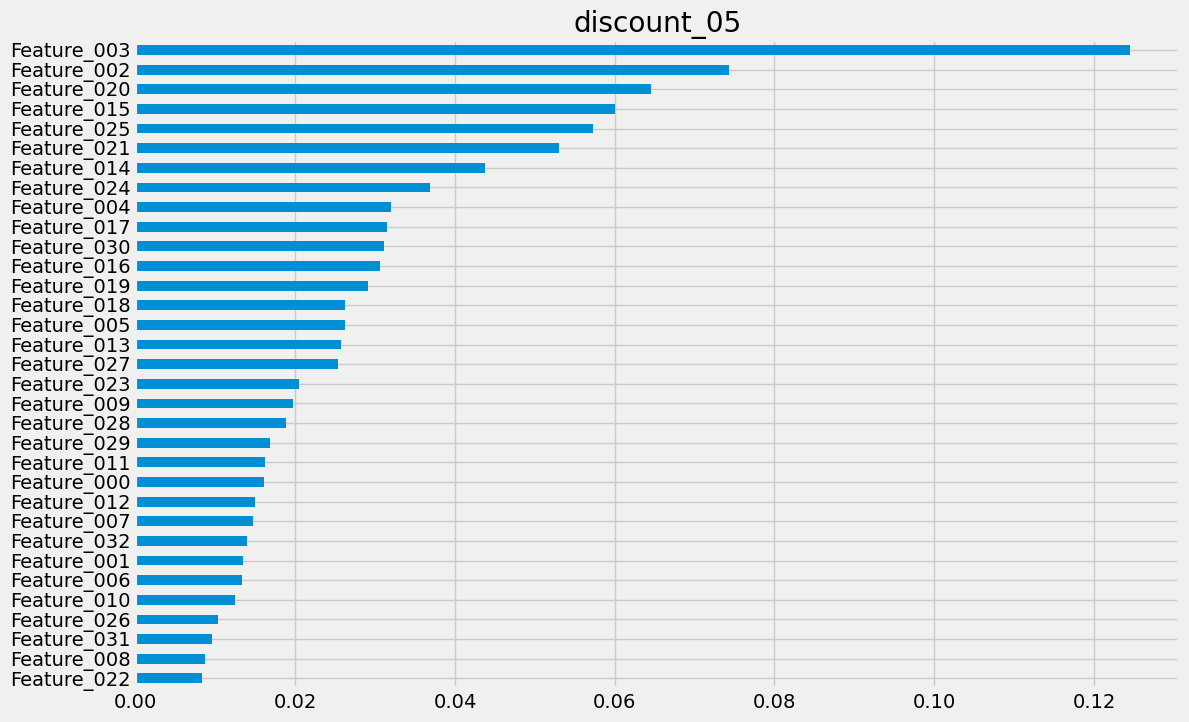

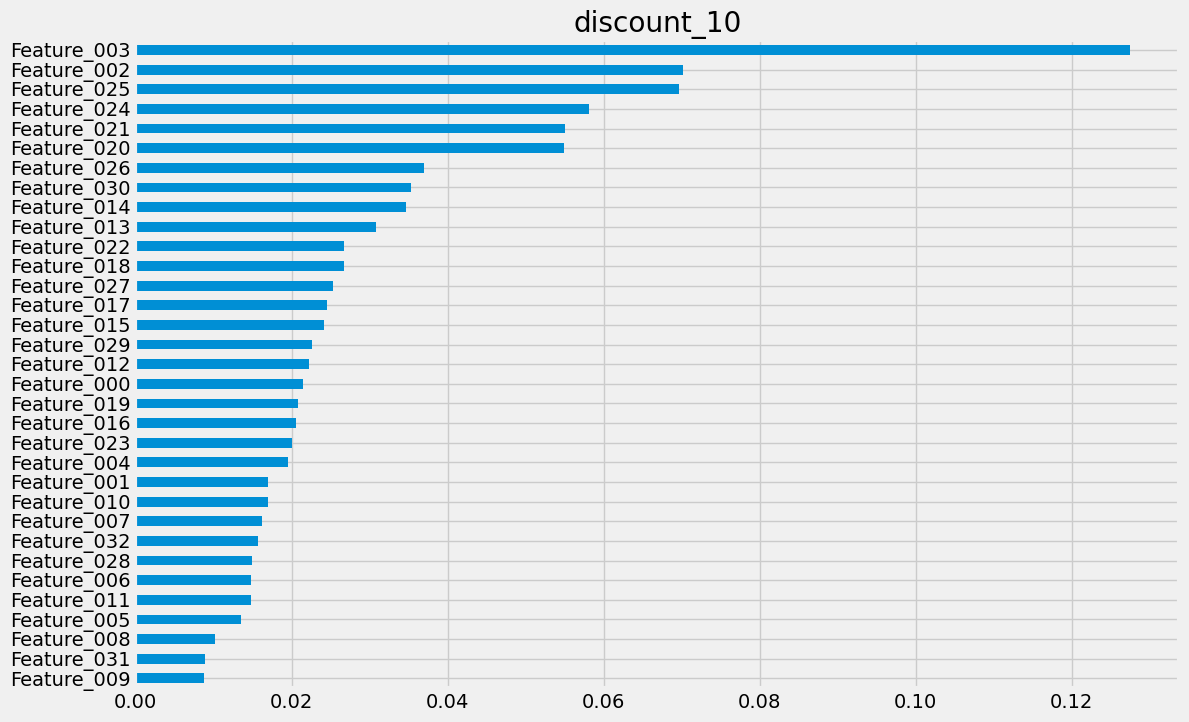

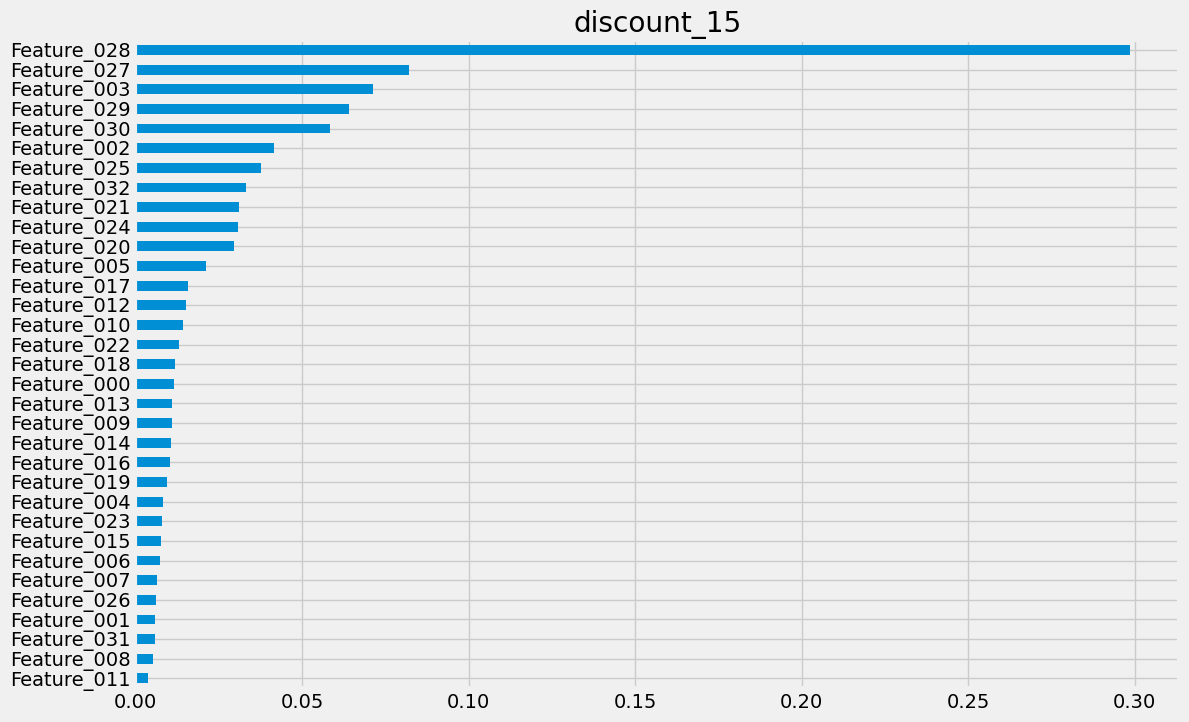

In [14]:
conversion_learner_t.plot_importance(X=df_train[X_names].values,
                        tau=conversion_learner_t_tau,
                        normalize=True,
                        method='auto')

## **Evaluating the CATE conversion model**

We can evaluate our models by looking at the Qini curves. We can use the CATE conversion model to evaluate the performance on both the Conversion and the Benefit as a function of the fraction of users targeted.

In [15]:
def eval_performance(model, df_eval, discount):

  df_eval['cate'] = model.predict(X=df_eval[X_names].values, treatment=df_eval['treatment_group_key'].values).tolist()
  df_eval[['cate_discount_05','cate_discount_10', 'cate_discount_15']] = pd.DataFrame(df_eval.cate.tolist(), index=df_eval.index)

  df_eval_disc = df_eval[df_eval['treatment_group_key'].isin(['control', discount])]
  df_eval_disc['treatment_num'] = df_eval_disc.apply(lambda x: 0 if x['treatment_group_key']=='control' else 1, axis=1)

  cate_col = 'cate_{}'.format(discount)

  df_eval_qini_conversion = pd.DataFrame([df_eval_disc[cate_col].ravel(),
                               df_eval_disc.treatment_num.ravel(),
                               df_eval_disc['conversion'].ravel()],
                               index=['S','w','y']).T

  df_eval_qini_benefit = pd.DataFrame([df_eval_disc[cate_col].ravel(),
                               df_eval_disc.treatment_num.ravel(),
                               df_eval_disc['benefit'].ravel()],
                               index=['S','w','y']).T

  cd_conversion = (get_qini(df_eval_qini_conversion)*2).reset_index()
  cd_conversion = cd_conversion/cd_conversion.shape[0]

  cd_benefit = (get_qini(df_eval_qini_benefit)*2).reset_index()
  cd_benefit = cd_benefit/cd_benefit.shape[0]

  return cd_conversion, cd_benefit

In [16]:
qini_05_conversion_test, qini_05_benefit_test = eval_performance(conversion_learner_t, df_test, 'discount_05')
qini_10_conversion_test, qini_10_benefit_test = eval_performance(conversion_learner_t, df_test, 'discount_10')
qini_15_conversion_test, qini_15_benefit_test = eval_performance(conversion_learner_t, df_test, 'discount_15')

Text(0.5, 1.0, 'CATE conversion vs Targeted Population')

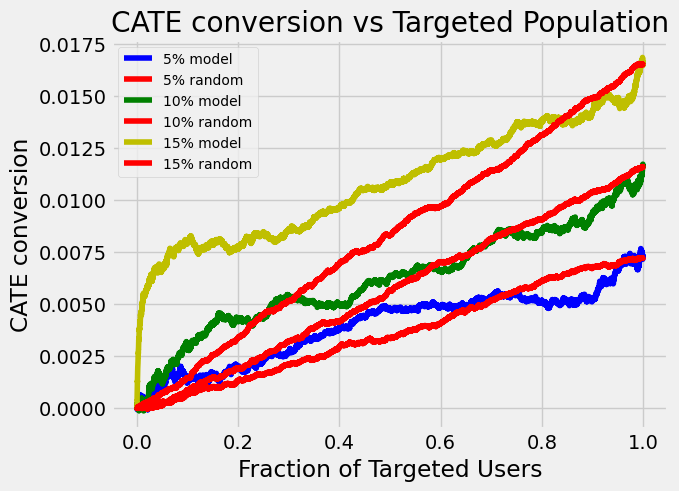

In [17]:
ax_conversion = qini_05_conversion_test.plot(x='index',y='S',color='b')
qini_05_conversion_test.plot(ax=ax_conversion,x='index',y='Random',color='r')
qini_10_conversion_test.plot(ax=ax_conversion, x='index',y='S', color='g')
qini_10_conversion_test.plot(ax=ax_conversion, x='index',y='Random', color='r')
qini_15_conversion_test.plot(ax=ax_conversion, x='index',y='S', color='y')
qini_15_conversion_test.plot(ax=ax_conversion, x='index',y='Random', color='r')
ax_conversion.legend(['5% model', '5% random', '10% model', '10% random', '15% model', '15% random'], prop={'size': 10})
ax_conversion.set_xlabel('Fraction of Targeted Users')
ax_conversion.set_ylabel('CATE conversion')
ax_conversion.set_title('CATE conversion vs Targeted Population')

Text(0.5, 1.0, 'CATE benefit vs Targeted Population')

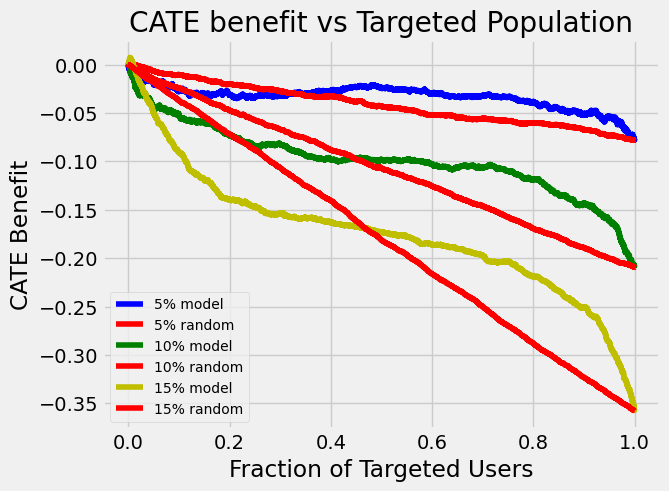

In [18]:
ax_benefit = qini_05_benefit_test.plot(x='index',y='S',color='b')
qini_05_benefit_test.plot(ax=ax_benefit,x='index',y='Random',color='r')
qini_10_benefit_test.plot(ax=ax_benefit, x='index',y='S', color='g')
qini_10_benefit_test.plot(ax=ax_benefit, x='index',y='Random', color='r')
qini_15_benefit_test.plot(ax=ax_benefit, x='index',y='S', color='y')
qini_15_benefit_test.plot(ax=ax_benefit, x='index',y='Random', color='r')
ax_benefit.legend(['5% model', '5% random', '10% model', '10% random', '15% model', '15% random'], prop={'size': 10})
ax_benefit.set_xlabel('Fraction of Targeted Users')
ax_benefit.set_ylabel('CATE Benefit')
ax_benefit.set_title('CATE benefit vs Targeted Population')

To simplify the comparison, we can plot the CATE Benefit as a function of the CATE conversion.

In [19]:
qini_05_conc_test = pd.concat([qini_05_conversion_test[['S']], qini_05_benefit_test[['S']]], axis=1)
qini_05_conc_test.columns = ['cate_conversion', 'cate_benefit']

qini_10_conc_test = pd.concat([qini_10_conversion_test[['S']], qini_10_benefit_test[['S']]], axis=1)
qini_10_conc_test.columns = ['cate_conversion', 'cate_benefit']

qini_15_conc_test = pd.concat([qini_15_conversion_test[['S']], qini_15_benefit_test[['S']]], axis=1)
qini_15_conc_test.columns = ['cate_conversion', 'cate_benefit']

Text(0.5, 1.0, 'CATE benefit vs CATE conversion')

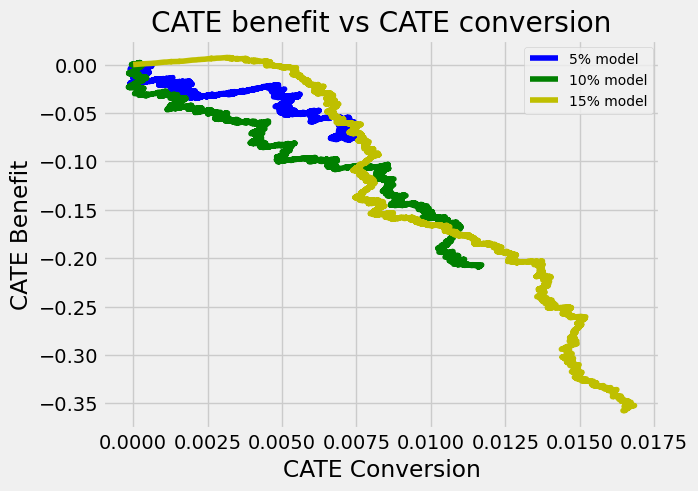

In [20]:
ax_comp = qini_05_conc_test.plot(x='cate_conversion',y='cate_benefit',color='b')
qini_10_conc_test.plot(ax=ax_comp, x='cate_conversion',y='cate_benefit',color='g')
qini_15_conc_test.plot(ax=ax_comp, x='cate_conversion',y='cate_benefit',color='y')
ax_comp.legend(['5% model', '10% model','15% model'], prop={'size': 10})
ax_comp.set_xlabel('CATE Conversion')
ax_comp.set_ylabel('CATE Benefit')
ax_comp.set_title('CATE benefit vs CATE conversion')

In the plot above we can see that the CATE Conversion model gives us the opportunity to considerable improve the performance of the discount.

# **Modeling the CATE Benefit**

In the section above we trained a T-Learner on the conversion label. Similarly we can now train a T-Learner on the benefit label, and use the model predictions to evaluate the performance on the CATE conversion and CATE benefit.

In [21]:
# Fit estimator
benefit_learner_t = BaseTRegressor(XGBRegressor(n_estimators = 50, max_depth=4, colsample_bytree=0.2, subsample=0.2), control_name='control')
#benefit_learner_t = BaseTRegressor(LinearRegression(), control_name='control')
benefit_learner_t_tau = benefit_learner_t.fit_predict(X=df_train[X_names].values, treatment=df_train['treatment_group_key'].values, y=df_train['benefit'].values)

## **Evaluating the CATE benefit model**

In [22]:
qini_05_conversion_test, qini_05_benefit_test = eval_performance(benefit_learner_t, df_test, 'discount_05')
qini_10_conversion_test, qini_10_benefit_test = eval_performance(benefit_learner_t, df_test, 'discount_10')
qini_15_conversion_test, qini_15_benefit_test = eval_performance(benefit_learner_t, df_test, 'discount_15')

Text(0.5, 1.0, 'CATE conversion vs Targeted Population')

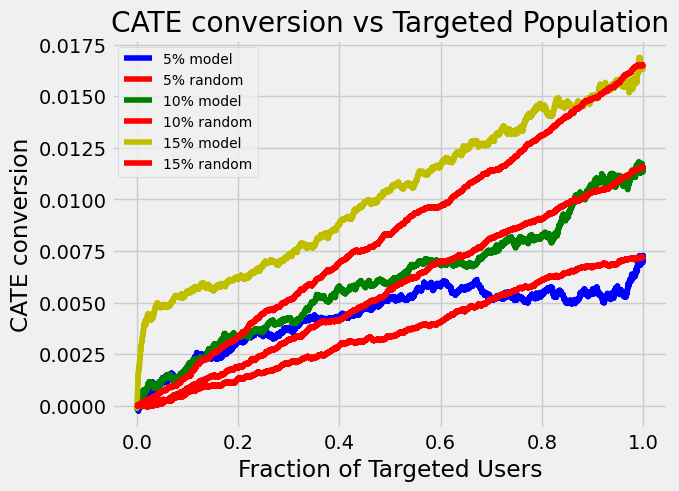

In [23]:
ax_conversion = qini_05_conversion_test.plot(x='index',y='S',color='b')
qini_05_conversion_test.plot(ax=ax_conversion,x='index',y='Random',color='r')
qini_10_conversion_test.plot(ax=ax_conversion, x='index',y='S', color='g')
qini_10_conversion_test.plot(ax=ax_conversion, x='index',y='Random', color='r')
qini_15_conversion_test.plot(ax=ax_conversion, x='index',y='S', color='y')
qini_15_conversion_test.plot(ax=ax_conversion, x='index',y='Random', color='r')
ax_conversion.legend(['5% model', '5% random', '10% model', '10% random', '15% model', '15% random'], prop={'size': 10})
ax_conversion.set_xlabel('Fraction of Targeted Users')
ax_conversion.set_ylabel('CATE conversion')
ax_conversion.set_title('CATE conversion vs Targeted Population')

Text(0.5, 1.0, 'CATE benefit vs Targeted Population')

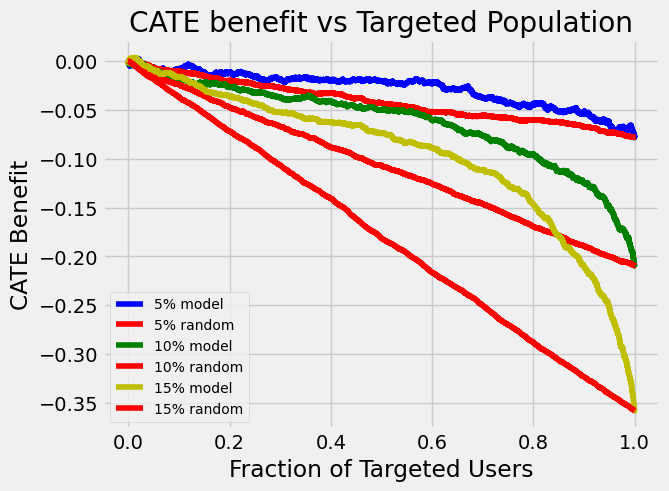

In [24]:
ax_benefit = qini_05_benefit_test.plot(x='index',y='S',color='b')
qini_05_benefit_test.plot(ax=ax_benefit,x='index',y='Random',color='r')
qini_10_benefit_test.plot(ax=ax_benefit, x='index',y='S', color='g')
qini_10_benefit_test.plot(ax=ax_benefit, x='index',y='Random', color='r')
qini_15_benefit_test.plot(ax=ax_benefit, x='index',y='S', color='y')
qini_15_benefit_test.plot(ax=ax_benefit, x='index',y='Random', color='r')
ax_benefit.legend(['5% model', '5% random', '10% model', '10% random', '15% model', '15% random'], prop={'size': 10})
ax_benefit.set_xlabel('Fraction of Targeted Users')
ax_benefit.set_ylabel('CATE Benefit')
ax_benefit.set_title('CATE benefit vs Targeted Population')

In [25]:
qini_05_conc_test = pd.concat([qini_05_conversion_test[['S']], qini_05_benefit_test[['S']]], axis=1)
qini_05_conc_test.columns = ['cate_conversion', 'cate_benefit']

qini_10_conc_test = pd.concat([qini_10_conversion_test[['S']], qini_10_benefit_test[['S']]], axis=1)
qini_10_conc_test.columns = ['cate_conversion', 'cate_benefit']

qini_15_conc_test = pd.concat([qini_15_conversion_test[['S']], qini_15_benefit_test[['S']]], axis=1)
qini_15_conc_test.columns = ['cate_conversion', 'cate_benefit']

Text(0.5, 1.0, 'CATE benefit vs CATE conversion')

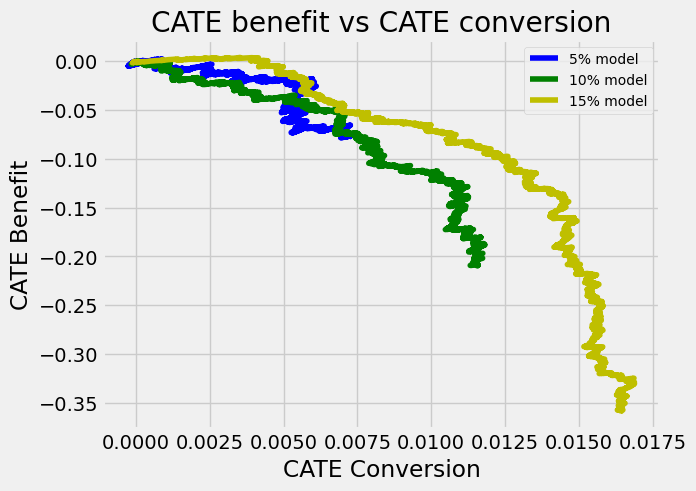

In [26]:
ax_comp = qini_05_conc_test.plot(x='cate_conversion',y='cate_benefit',color='b')
qini_10_conc_test.plot(ax=ax_comp, x='cate_conversion',y='cate_benefit',color='g')
qini_15_conc_test.plot(ax=ax_comp, x='cate_conversion',y='cate_benefit',color='y')
ax_comp.legend(['5% model', '10% model','15% model'], prop={'size': 10})
ax_comp.set_xlabel('CATE Conversion')
ax_comp.set_ylabel('CATE Benefit')
ax_comp.set_title('CATE benefit vs CATE conversion')

In the last plot for example we can see that there is a region where offering 15% discount to a targeted group of users is more efficient than giving 10% to everyone. We can obtain the same impact in overall conversion uplift while reducing our benefit loss considerably.